In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymongo
import time

from PIL import Image
from pprint import pprint
from wordcloud import WordCloud

%matplotlib inline

# Conexão com o MongoDB

In [2]:
client = pymongo.MongoClient()
db = client['IWD2021']  
collection = db.tweets_server_updated

# Funções

In [3]:
def query(collection: pymongo.collection.Collection, pipeline: list) -> list:
    query = list(collection.aggregate(pipeline, allowDiskUse=True))
    return query

In [4]:
def get_language(lang: str) -> str:
    bcp_lang = pd.read_csv('bcp47.csv')
    language = bcp_lang[bcp_lang['lang'] == lang]['language'].tolist()[0]
    return language

In [5]:
def get_hashtag_by_lang(collection: pymongo.collection.Collection, lang: str) -> list:
    pipeline = [
        {
            '$match': {
                'lang': lang
            }
        }, {
            '$project': {
                '_id': 0,
                'id': 1,
                'retweeted_status': {
                    '$ifNull': [
                        '$entities.hashtags.text', 
                        '$retweeted_status.extended_tweet.entities.hashtags.text'
                    ]
                }
            }
        }, {
            '$project': {
                'hashtags': '$retweeted_status'
            }
        }, {
            '$unwind': {
                'path': '$hashtags'
            }
        }, {
            '$group': {
                '_id': '$hashtags',
                'count': {
                    '$sum': 1
                }
            }
        }, {
            '$sort': {
                'count': -1
            }
        }
    ]
    
    document = list(collection.aggregate(pipeline=pipeline))
    return document

# Estatísticas

## Idiomas

In [6]:
pipeline1 = [
    {
        '$group': {
            '_id': '$lang',
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]

In [7]:
languages = query(collection=collection, pipeline=pipeline1)

In [8]:
num_languages = len(languages)
print(f'Número de idiomas presentes na base: {num_languages}')

Número de idiomas presentes na base: 66


In [9]:
languages_df = pd.DataFrame(languages)
languages_df.rename(columns={"_id": "language"}, inplace=True)
languages_df['language'] = languages_df['language'].apply(get_language)
languages_df.head(10)

,language,count
0,English,2459599
1,Spanish,1441175
2,Undefined,374940
3,Turkish,247199
4,Hindi,176731
5,Arabic,128177
6,Portuguese,124444
7,French,85162
8,Catalan,44291
9,German,30710


In [10]:
# languages_df.to_parquet('languagesiwd21.parquet.gzip', compression='gzip')
# languages_df = pd.read_parquet('languages.parquet.gzip')

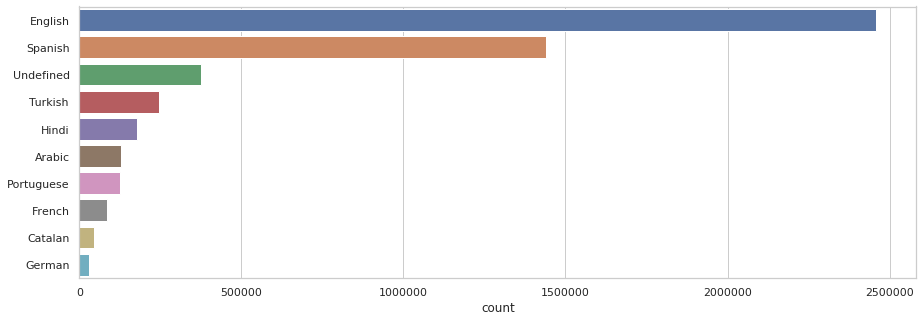

In [11]:
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
ax = sns.barplot(x='count', y='language', data=languages_df[0:10])
ax.set_ylabel('')
plt.show()

## Hashtags

In [12]:
pipeline2 = [
    {
        '$project': {
            '_id': 0, 
            'id': 1, 
            'retweeted_status': {
                '$ifNull': [
                    '$entities.hashtags.text', 
                    '$retweeted_status.extended_tweet.entities.hashtags.text'
                ]
            }
        }
    }, {
        '$project': {
            'hashtag': '$retweeted_status'
        }
    }, {
        '$unwind': {
            'path': '$hashtag'
        }
    }, {
        '$group': {
            '_id': '$hashtag', 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]

In [13]:
hashtags = query(collection=collection, pipeline=pipeline2)

In [14]:
num_hashtags = len(hashtags)
print(f'Número de hashtags presentes na base: {num_hashtags}')

Número de hashtags presentes na base: 270110


In [15]:
hashtags_df = pd.DataFrame(hashtags)
hashtags_df.rename(columns={"_id": "hashtag"}, inplace=True)
hashtags_df.head(10)

,hashtag,count
0,InternationalWomensDay,1090107
1,8M2021,609069
2,IWD2021,331548
3,WomensDay,218875
4,8M,199985
5,DiaInternacionalDeLaMujer,141397
6,8MartDünyaKadınlarGünü,122447
7,ChooseToChallenge,105118
8,8Marzo2021,100309
9,يوم_المراه_العالمي,82577


In [16]:
# hashtags_df.to_parquet('hashtagsiwd2021.parquet.gzip', compression='gzip')
# hashtags_df = pd.read_parquet('hashtags.parquet.gzip')

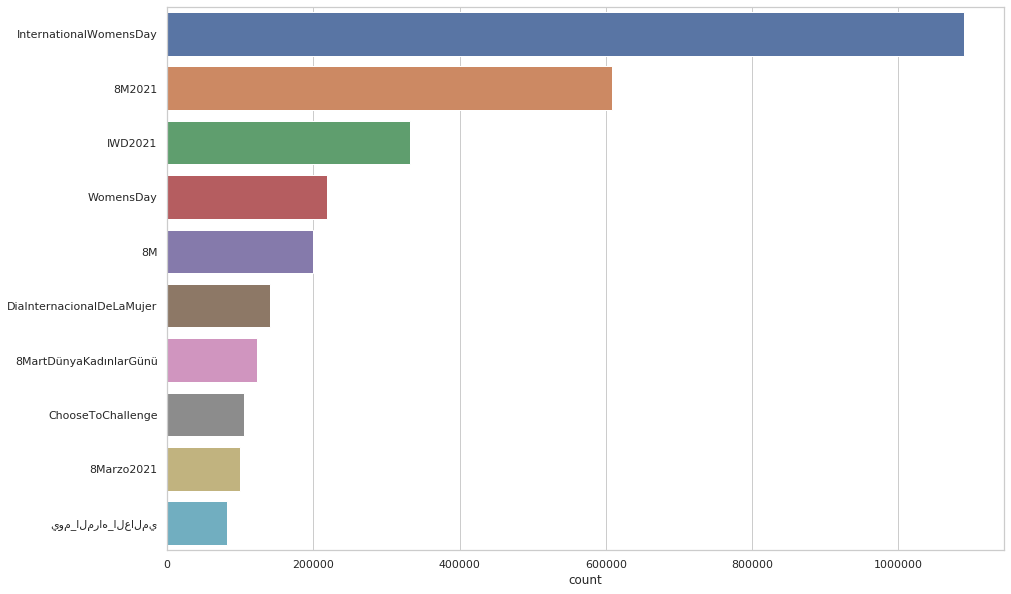

In [17]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
ax = sns.barplot(x='count', y='hashtag', data=hashtags_df[0:10])
ax.set_ylabel('')
plt.show()

### Hashtags por idioma do tweets

In [18]:
hashtags_en = get_hashtag_by_lang(lang='en', collection=collection)
hashtags_es = get_hashtag_by_lang(lang='es', collection=collection)
hashtags_pt = get_hashtag_by_lang(lang='pt', collection=collection)

In [19]:
hashtags_en_df = pd.DataFrame(hashtags_en)
hashtags_en_df.rename(columns={"_id": "hashtag"}, inplace=True)
hashtags_en_df.head(10)

,hashtag,count
0,InternationalWomensDay,835727
1,IWD2021,275607
2,WomensDay,116310
3,ChooseToChallenge,89434
4,internationalwomensday,44675
5,IWD,24766
6,8M2021,19150
7,internationalwomensday2021,17579
8,GenerationEquality,14725
9,NariShakti,14002


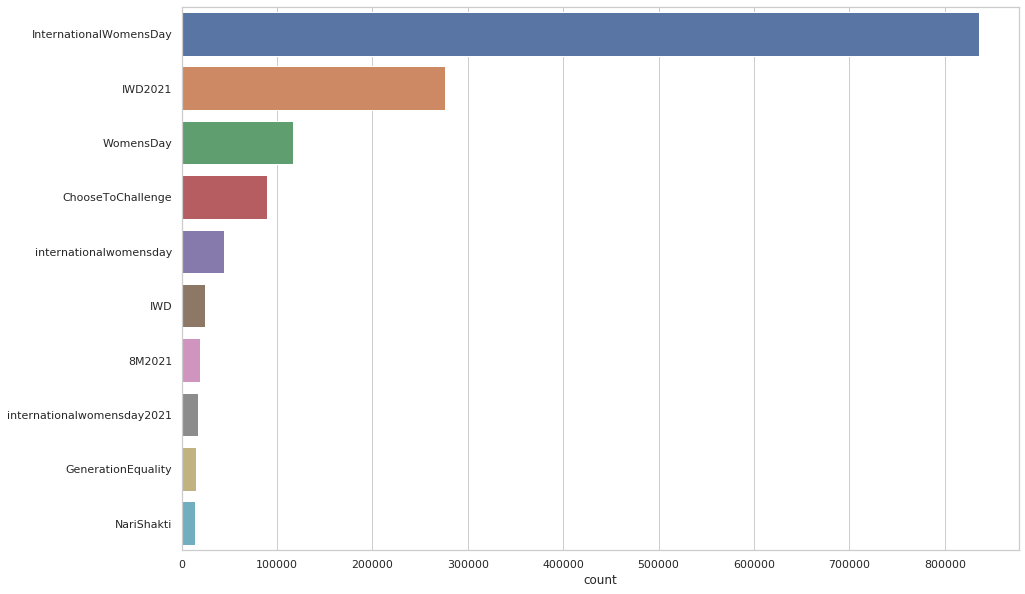

In [20]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
ax = sns.barplot(x='count', y='hashtag', data=hashtags_en_df[0:10])
ax.set_ylabel('')
plt.show()

In [21]:
hashtags_es_df = pd.DataFrame(hashtags_es)
hashtags_es_df.rename(columns={"_id": "hashtag"}, inplace=True)
hashtags_es_df.head(10)

,hashtag,count
0,8M2021,489834
1,8M,161902
2,DiaInternacionalDeLaMujer,118174
3,8Marzo2021,77984
4,NiUnaMenos,44518
5,8m,19746
6,InternationalWomensDay,17477
7,Diadelamujer,17424
8,NiUnaMas,14905
9,DíaInternacionalDeLaMujer,13655


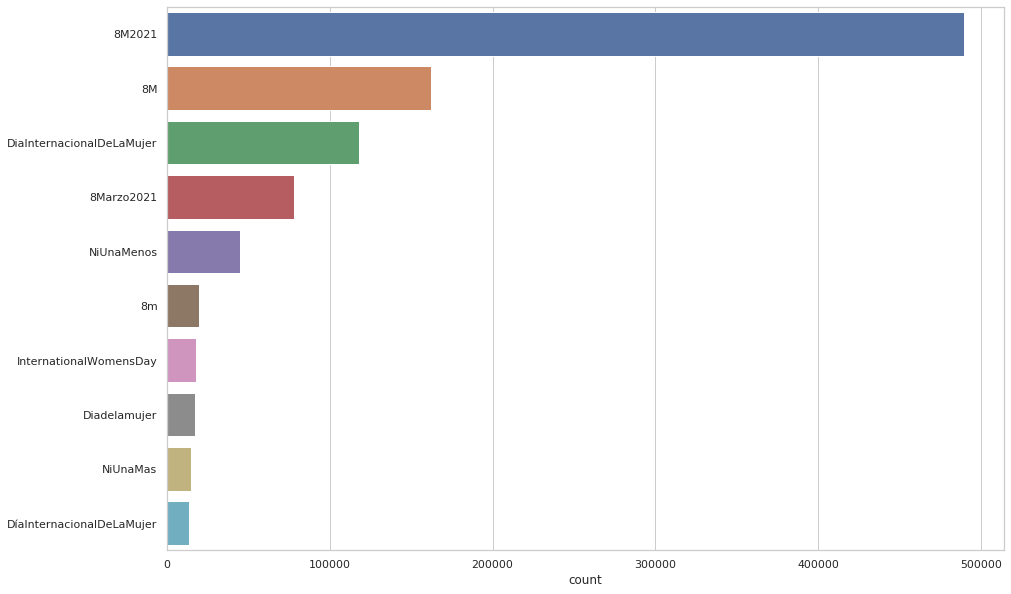

In [22]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
ax = sns.barplot(x='count', y='hashtag', data=hashtags_es_df[0:10])
ax.set_ylabel('')
plt.show()

In [23]:
hashtags_pt_df = pd.DataFrame(hashtags_pt)
hashtags_pt_df.rename(columns={"_id": "hashtag"}, inplace=True)
hashtags_pt_df.head(10)

,hashtag,count
0,DiaDasMulheres,18048
1,8M2021,6740
2,8M,4699
3,InternationalWomensDay,4400
4,diadamulher,2712
5,OlhaPraEla,2025
6,BBB21,1710
7,DiaDaMulher,1699
8,WomensDay,1351
9,diainternacionaldamulher,974


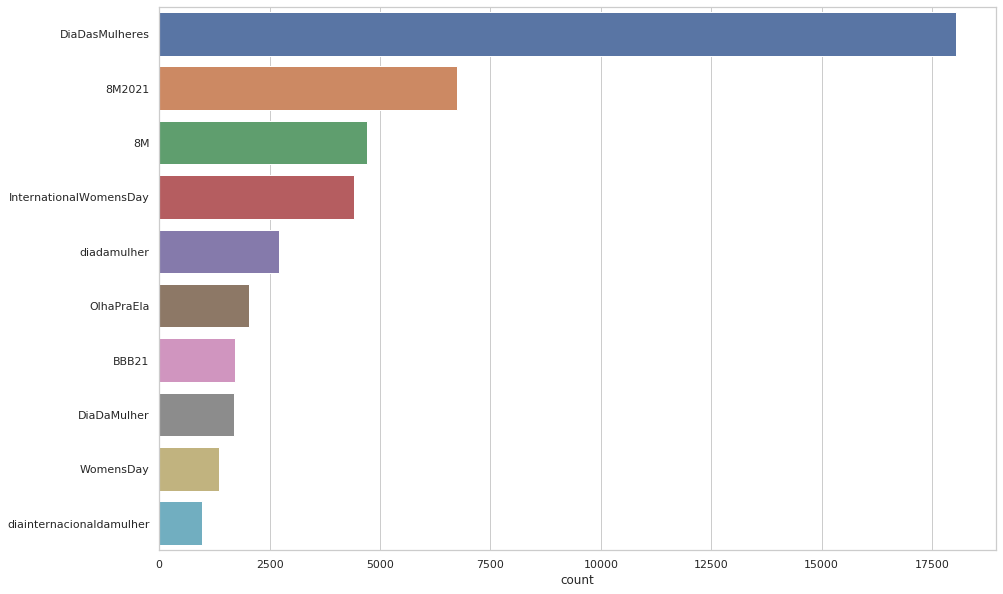

In [24]:
plt.figure(figsize=(15,10))
sns.set(style="whitegrid")
ax = sns.barplot(x='count', y='hashtag', data=hashtags_pt_df[0:10])
ax.set_ylabel('')
plt.show()

In [25]:
hashtags_en_df.to_parquet('hashtags_eniwd2021.parquet.gzip', compression='gzip')
hashtags_es_df.to_parquet('hashtags_esiwd2021.parquet.gzip', compression='gzip')
hashtags_pt_df.to_parquet('hashtags_ptiwd2021.parquet.gzip', compression='gzip')

# hashtags_en_df = pd.read_parquet('hashtags_en.parquet.gzip')
# hashtags_es_df = pd.read_parquet('hashtags_es.parquet.gzip')
# hashtags_pt_df = pd.read_parquet('hashtags_pt.parquet.gzip')

## Tweets ao longo do tempo

In [26]:
pipeline3 = [
    {
        '$project': {
            'date': {
                '$dateFromString': {
                    'dateString': '$created_at'
                }
            }
        }
    }, {
        '$project': {
            'date': {
                '$dateToString': {
                    'format': '%d/%m %H:00', 
                    'date': '$date'
                }
            }
        }
    }, {
        '$group': {
            '_id': '$date', 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            '_id': 1
        }
    }
]

In [27]:
tweets_times = query(collection=collection, pipeline=pipeline3)

In [28]:
tweets_times_df = pd.DataFrame(tweets_times)
tweets_times_df.rename(columns={"_id": "data_hora"}, inplace=True)
tweets_times_df['cumsum'] = tweets_times_df['count'].cumsum()
tweets_times_df.head(10)

,data_hora,count,cumsum
0,07/03 19:00,11271,11271
1,07/03 20:00,14757,26028
2,07/03 21:00,32834,58862
3,07/03 22:00,41653,100515
4,07/03 23:00,29684,130199
5,08/03 00:00,25539,155738
6,08/03 01:00,31348,187086
7,08/03 02:00,63306,250392
8,08/03 03:00,119367,369759
9,08/03 04:00,162576,532335


In [29]:
data = lambda x: x[:5]
hora = lambda x: x[6:]

In [30]:
tweets_times_df['data'] = tweets_times_df.data_hora.apply(data)
tweets_times_df['hora'] = tweets_times_df.data_hora.apply(hora)

In [31]:
tweets_times_df.head()

,data_hora,count,cumsum,data,hora
0,07/03 19:00,11271,11271,07/03,19:00
1,07/03 20:00,14757,26028,07/03,20:00
2,07/03 21:00,32834,58862,07/03,21:00
3,07/03 22:00,41653,100515,07/03,22:00
4,07/03 23:00,29684,130199,07/03,23:00


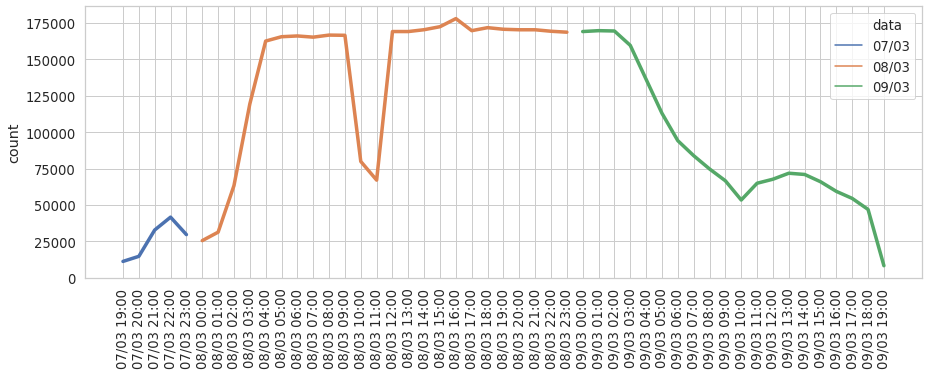

In [32]:
plt.figure(figsize=(15,5))
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)
ax = sns.lineplot(data=tweets_times_df, x="data_hora", y="count", hue="data", linewidth=3.5,)
plt.xticks(rotation=90)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('')
# ax.tick_params(axis='x', colors='black')
plt.show()

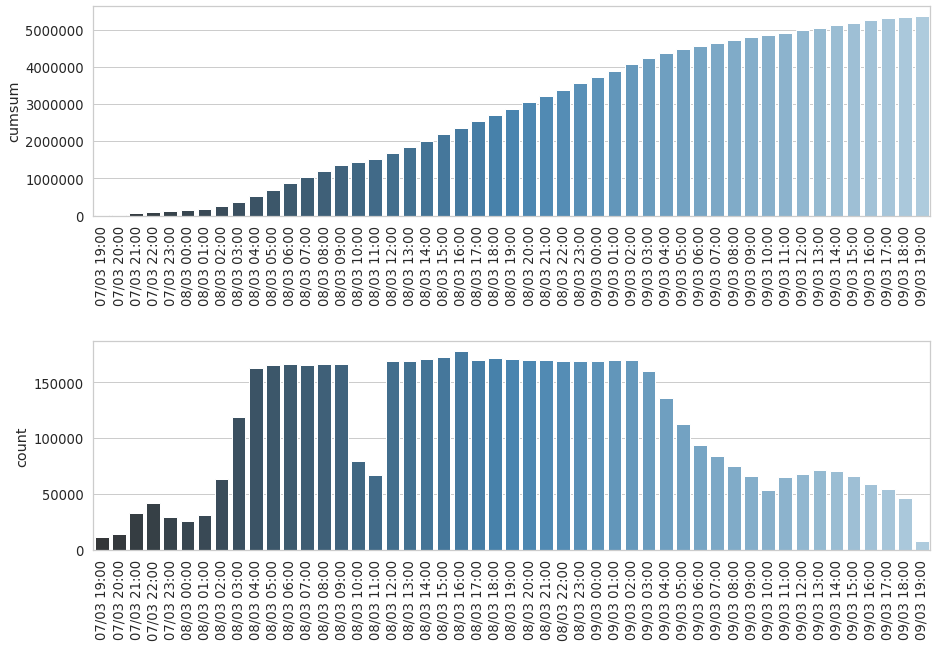

In [33]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(15, 10))

sns.barplot(x='data_hora', 
            y='cumsum', 
            data=tweets_times_df, 
            ax=ax1, 
            palette="Blues_d")

sns.barplot(x='data_hora', 
            y='count', 
            data=tweets_times_df, 
            ax=ax2, 
            palette="Blues_d")

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_xlabel('')

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_xlabel('')

plt.subplots_adjust(hspace=0.6)
plt.show()

## Perfis

In [34]:
pipeline4 = [
    {
        '$project': {
            '_id': 0, 
            'created_at': {
                '$dateFromString': {
                    'dateString': '$user.created_at'
                }
            }, 
            'id': '$user.id_str', 
            'screen_name': '$user.screen_name', 
            'name': '$user.name', 
            'tweet_count': '$user.statuses_count', 
            'fav_count': '$user.favourites_count', 
            'followers': '$user.followers_count', 
            'following': '$user.friends_count'
        }
    }, {
        '$project': {
            'date_creation': {
                '$dateToString': {
                    'format': '%d/%m/%Y', 
                    'date': '$created_at'
                }
            }, 
            'id': 1, 
            'screen_name': 1, 
            'name': 1, 
            'tweet_count': 1, 
            'fav_count': 1, 
            'followers': 1, 
            'following': 1
        }
    }, {
        '$group': {
            '_id': '$id', 
            'date_creation': {
                '$first': '$date_creation'
            }, 
            'screen_name': {
                '$first': '$screen_name'
            }, 
            'name': {
                '$first': '$name'
            }, 
            'tweet_count': {
                '$first': '$tweet_count'
            }, 
            'fav_count': {
                '$first': '$fav_count'
            }, 
            'followers': {
                '$first': '$followers'
            }, 
            'following': {
                '$first': '$following'
            }, 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]

In [35]:
perfis = query(collection=collection, pipeline=pipeline4)

In [36]:
num_perfis = len(perfis)
print(f'Número de perfis presentes na base: {num_perfis}')

Número de perfis presentes na base: 2817630


In [37]:
perfis_df = pd.DataFrame(perfis)

In [38]:
perfis_df.head(10)

,_id,date_creation,screen_name,name,tweet_count,fav_count,followers,following,count
0,1143528514550927361,25/06/2019,femtech_,FemTech_🖥👩🏽‍💻,1141419,95,20014,2,1910
1,1308040042724519939,21/09/2020,in_stemm,Women Who Rule!,40321,16,1539,15,1695
2,1251444236957782016,18/04/2020,Jonnala48318620,Jonnalagadda Rajesh,99060,17287,589,494,837
3,1327935633445199874,15/11/2020,BotFemale,Female Coders Bot,143395,95,1271,1,653
4,968250860,24/11/2012,joshualeclair1,joshua leclair,76323,19,402,2996,548
5,1305144829853265928,13/09/2020,YoelCastellan12,Yoel Castellano Rodríguez,2332,2489,153,205,544
6,1366766892518637569,02/03/2021,carrizal_cdi,CDI CARRIZAL,21295,10595,125,75,544
7,1347924749876228099,09/01/2021,anitas15873144,anita s,50798,45987,231,238,524
8,1367680002775412736,05/03/2021,Bharat28441114,Bharat,1945,1985,14,8,442
9,1269215553316548608,06/06/2020,Neetuom1,Neetuom,108446,67005,190,40,433


## Tweets

In [39]:
pipeline5 = [
    {
        '$project': {
            'tweet_id': '$id_str', 
            'date': {
                '$dateFromString': {
                    'dateString': '$created_at'
                }
            }, 
            'author': '$user.screen_name',
            'tweet_text': {
                '$ifNull': [
                    '$retweeted_status.full_text', '$full_text'
                ]
            }, 
            'language': '$lang',
            'num_likes': '$favorite_count', 
            'num_retweets': '$retweet_count', 
            'quoted_status_id': {
                '$ifNull': [
                    '$quoted_status_id_str', None
                ]
            }, 
            'retweeted_status_id': {
                '$ifNull': [
                    '$retweeted_status.id_str', None
                ]
            }, 
            'reply_to_user': {
                '$ifNull': [
                    '$in_reply_to_user_id_str', None
                ]
            }, 
            'reply_to_status': {
                '$ifNull': [
                    '$in_reply_to_status_id_str', None
                ]
            } 
        }
    }, {
        '$project': {
            '_id': 0, 
            'tweet_id': 1, 
            'date': {
                '$dateToString': {
                    'format': '%d/%m/%Y %H:%M:%S', 
                    'date': '$date'
                }
            }, 
            'author': 1,
            'tweet_text': 1, 
            'language': 1,
            'num_likes': 1, 
            'num_retweets': 1, 
            'quoted_status_id': 1, 
            'retweeted_status_id': 1, 
            'reply_to_user': 1, 
            'reply_to_status': 1
        }
    }
]

In [40]:
tweets = query(collection=collection, pipeline=pipeline5)

In [41]:
tweets[0]

{'tweet_id': '1368641229731360773',
 'author': 'HildaMcevoy',
 'tweet_text': "@MargaretEWard The irony that I can't attend any of these online events...because my kids aren't in school and I have to still home school them, is NOT lost on me 😂😭😂😭 Cheers for being in our corner, Margaret, while forging your own path too! #IWD2021",
 'language': 'en',
 'num_likes': 4,
 'num_retweets': 0,
 'quoted_status_id': None,
 'retweeted_status_id': None,
 'reply_to_user': '17868868',
 'reply_to_status': '1368629846872580097',
 'date': '07/03/2021 19:14:31'}

In [42]:
num_tweets = len(tweets)
print(f'Documentos presentes na base: {num_tweets}')

Documentos presentes na base: 5360203


In [43]:
tweets_df = pd.DataFrame(tweets)

In [44]:
tweets_df.head(10)

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
0,1368641229731360773,HildaMcevoy,@MargaretEWard The irony that I can't attend a...,en,4,0,None,None,17868868,1368629846872580097,07/03/2021 19:14:31
1,1368641259347320842,satyar2021,There is no denying women have been disproport...,en,0,58,None,1367605354570342402,None,None,07/03/2021 19:14:39
2,1368641305396408320,NoWineImFine,"‘I am going to be a bit ranty today, because t...",en,3,0,None,None,None,None,07/03/2021 19:14:49
3,1368641314900742144,eusebius_m,✨캡틴 마블 개봉 2주년✨\n#WomensHistoryMonth #세계여성의날 #I...,ko,0,63,None,1368577214921408518,None,None,07/03/2021 19:14:52
4,1368641259284221954,AlydiaSecosana,Who are the women that inspire you?\n\nOn the ...,en,0,700,None,1368601342307168256,None,None,07/03/2021 19:14:38
5,1368641251868872710,delaram_aram,شما زنان ایران می توانید و باید پیروزی را بساز...,fa,0,627,None,1368592247541825537,None,None,07/03/2021 19:14:37
6,1368641274023149570,B0nB0n__,#IWD2021 https://t.co/SXEoBD2ERw,und,0,119,None,1368539631915065348,None,None,07/03/2021 19:14:42
7,1368641318398885892,glorydays___CB,THANK U GIRLZ #InternationalWomensDay https://...,en,0,78,None,1368625731165712385,None,None,07/03/2021 19:14:53
8,1368641301294571524,Patrice4020,Wangari Maathai arrive en 4ème position avec 3...,fr,0,1,1368629751364083712,1368630082156249089,None,None,07/03/2021 19:14:49
9,1368641270222970882,poohpeewee,RESPECT WOMEN.\n\nThat's It. That's the Tweet....,en,0,7631,None,1368525594737131520,None,None,07/03/2021 19:14:41


In [45]:
tweets_df.to_parquet('tweetsiwd2021.parquet.gzip', compression='gzip')

### Frequência

In [46]:
num_unique_tweets = len(tweets_df['tweet_text'].value_counts())
num_unique_tweets

1486849

In [47]:
text_df = pd.DataFrame(tweets_df['tweet_text'].value_counts(
).rename_axis('unique_values').reset_index(name='counts'))

pd.set_option('display.max_colwidth', None)
text_df.head(10)

,unique_values,counts
0,I wish all trans girls who aren't able to come out for whatever reason a very pleasant international women's day,39110
1,hoy es un muy buen día para recordar este vídeo #8M2021 https://t.co/Havt7uQK6d,15121
2,Nos sembraron miedo y nos crecieron alas #8M2021 https://t.co/w3zdkC2gQS,13149
3,#ROSÉ curated her own playlist for @applemusic in honor of International Womens Day. \nStream and celebrate all the amazing women in the world 🌹 \n\n#로제 #BLACKPINK #블랙핑크 #R #OnTheGround #AppleMusic #IWD2021 #InternationalWomensDay \n\n🎧 https://t.co/MdmIzuYEuJ,12924
4,"Every day let’s celebrate women and girls around the world. Here’s a special thank you to the women who have worked tirelessly during COVID to ensure vital services have continued, and to the young women @UNICEF supports. Thank you for keeping them happy healthy and safe #IWD2021 https://t.co/1MCOK7hV0l",11537
5,"NUNCA olvidemos lo que hizo Marisela Escobedo, luchó por el feminicidio de su hija, SE ENFRENTÓ A UNA RED DE NARCOS Y CON EL GOBERNADOR, el feminicida de su hija quedo impune, MARISELA ESCOBEDO FUE ASESINADA FRENTE AL PALACIO DE GOBIERNO \n#8M2021 #8Marzo2021 https://t.co/HnU1ak9S0z",10389
6,#InternationalWomensDay,8639
7,I'm happy because I'm a woman. Happy International women's Day!!#InternationalWomensDay \n#세계여성의날 #WeAreWomen,7771
8,#InternationalWomensDay https://t.co/NcoHgdr2rN,7109
9,"VERGONHA!! No Dia Internacional da Mulher, o governo Bolsonaro não aceitou assinar na ONU a declaração do Conselho de Direitos Humanos que assume compromissos na defesa da saúde da mulher. Mais de 60 países assinaram. O Brasil não.",6919


In [49]:
text_df.to_parquet('textiwd2021.parquet.gzip', compression='gzip')

#### = 1

In [50]:
index = text_df['counts']==1
num_one_text = len(text_df[index])
num_one_text

1034937

#### > 1

In [51]:
num_repeat_text = num_tweets - num_one_text
num_repeat_text

4325266

### Curtidas

In [52]:
likes_df = tweets_df.sort_values(by=['num_likes'], ascending=False)

In [53]:
def highlight_cols(s):
    color = '#D3D3D3'
    return 'background-color: %s' % color

likes_df.iloc[0:10].style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['num_likes']])

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
3045115,1368763578908557317,gh0st_teeth,I wish all trans girls who aren't able to come out for whatever reason a very pleasant international women's day,en,333933,93937,None,None,None,None,08/03/2021 03:20:42
1349098,1368972855015174145,KylieJenner,#internationalwomensday 🤍 https://t.co/1RUxMvQR9b,und,117842,5633,None,None,None,None,08/03/2021 17:12:17
3628434,1368904837409234947,Nihaachu,Cant believe people still dont know basic human decency and even a tad bit of empathy in 2021 https://t.co/UGkYMeMfj2,en,99423,3623,1368904389562400771,None,None,None,08/03/2021 12:42:00
4277523,1369032670806646789,DisguisedToast,shoutout to all the wonderful women in the scene that has to constantly deal with people questioning their achievements and minimizing their success #InternationalWomensDay,en,89674,5677,None,None,None,None,08/03/2021 21:09:58
4537509,1369084799391043584,lanuskylive,#InternationalWomensDay YAY (I know it ended 30 minutes but still) YAYYYY,en,64474,735,None,None,None,None,09/03/2021 00:37:07
4282609,1369033694132891649,Ashton5SOS,"Have a wonderful international woman’s day. God is a woman! Thank you for the teachings, the guidance, the abundance of love and care, the strength and the ever growing abundance of influential woman on Mother Earth. Thank you to the mother’s ❤️",en,64396,12710,None,None,None,None,08/03/2021 21:14:02
60685,1368704526140780547,VancityReynolds,Happy International Women’s Day! Shoutout to local Women too. You’re also pretty great. #InternationalWomensDay,en,64051,4503,None,None,None,None,07/03/2021 23:26:02
4441800,1369064529611620352,_jaylarose,"2 months from now, you can start calling me Dr. Thompson 💊#internationalwomensday https://t.co/FK8E2NAfmC",en,63751,5048,None,None,None,None,08/03/2021 23:16:34
3657962,1368910716862947330,wizkidayo,#InternationalWomensDay,und,60783,11732,None,None,None,None,08/03/2021 13:05:22
956534,1368911572870045706,FLOTUS,"On this #InternationalWomensDay, we celebrate the resilience and courage of women everywhere. “Each time a woman stands up for herself...she stands up for all women.” - Maya Angelou",en,57830,10003,None,None,None,None,08/03/2021 13:08:46


In [55]:
likes_df.to_parquet('likesiwd2021.parquet.gzip', compression='gzip')

### Retweets

In [56]:
retweets_df = tweets_df.sort_values(by=['num_retweets'], ascending=False)

In [57]:
retweets_df.iloc[0:10].style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['num_retweets']])

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
76662,1368720667231797250,wallsxmalik,Happy International Women's Day. I hope it was a wonderful one. H,en,0,236850,None,707348811547541504,None,None,08/03/2021 00:30:11
98434,1368741893836861446,harryystanacc,Happy International Women's Day. I hope it was a wonderful one. H,en,0,236849,None,707348811547541504,None,None,08/03/2021 01:54:32
37912,1368686751795974145,RAINBERRYDIOR,Happy International Women's Day. I hope it was a wonderful one. H,en,0,236848,None,707348811547541504,None,None,07/03/2021 22:15:25
80775,1368725340043042822,hrrybutterfly,Happy International Women's Day. I hope it was a wonderful one. H,en,0,236847,None,707348811547541504,None,None,08/03/2021 00:48:45
74969,1368718739894640641,shlitwic,Happy International Women's Day. I hope it was a wonderful one. H,en,0,236847,None,707348811547541504,None,None,08/03/2021 00:22:31
74240,1368717882964721669,xsilkylily,Happy International Women's Day. I hope it was a wonderful one. H,en,0,236847,None,707348811547541504,None,None,08/03/2021 00:19:07
65216,1368708766766673923,m4vvkea,Happy International Women's Day. I hope it was a wonderful one. H,en,0,236847,None,707348811547541504,None,None,07/03/2021 23:42:54
67035,1368710637921202179,zosiaye1,Happy International Women's Day. I hope it was a wonderful one. H,en,0,236847,None,707348811547541504,None,None,07/03/2021 23:50:20
65639,1368709232846110721,Marysia21303,Happy International Women's Day. I hope it was a wonderful one. H,en,0,236847,None,707348811547541504,None,None,07/03/2021 23:44:45
67072,1368710603116847106,F1NELI1NE,Happy International Women's Day. I hope it was a wonderful one. H,en,0,236847,None,707348811547541504,None,None,07/03/2021 23:50:11


In [59]:
retweets_df.to_parquet('retweetsiwd2021.parquet.gzip', compression='gzip')

In [60]:
num_retweets = tweets_df[tweets_df['retweeted_status_id'].notnull()].shape[0]
print(f'Número de tweets que são retweets: {num_retweets}')

Número de tweets que são retweets: 4180512


#### Ranking retweets

In [61]:
retweets_df[retweets_df['retweeted_status_id'].isnull()].iloc[0:10].style.applymap(highlight_cols, subset=pd.IndexSlice[:, ['num_retweets']])

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
3045115,1368763578908557317,gh0st_teeth,I wish all trans girls who aren't able to come out for whatever reason a very pleasant international women's day,en,333933,93937,None,None,None,None,08/03/2021 03:20:42
382839,1368804908443394048,choi_bts2,I'm happy because I'm a woman. Happy International women's Day!!#InternationalWomensDay #세계여성의날 #WeAreWomen,en,53522,15730,None,None,None,None,08/03/2021 06:04:55
4282609,1369033694132891649,Ashton5SOS,"Have a wonderful international woman’s day. God is a woman! Thank you for the teachings, the guidance, the abundance of love and care, the strength and the ever growing abundance of influential woman on Mother Earth. Thank you to the mother’s ❤️",en,64396,12710,None,None,None,None,08/03/2021 21:14:02
465763,1368818832454877184,CBSNews,WATCH: Women turned a metal barrier — erected around Mexico’s National Palace ahead of International Women's Day — into a memorial for victims of femicide and rape. https://t.co/mFkDbriNo5,en,26821,12094,None,None,None,None,08/03/2021 07:00:15
3657962,1368910716862947330,wizkidayo,#InternationalWomensDay,und,60783,11732,None,None,None,None,08/03/2021 13:05:22
1026250,1368921535356997633,annetdonahue,happy international women's day https://t.co/g7VL0Wjzwd,en,54788,10708,None,None,None,None,08/03/2021 13:48:22
956534,1368911572870045706,FLOTUS,"On this #InternationalWomensDay, we celebrate the resilience and courage of women everywhere. “Each time a woman stands up for herself...she stands up for all women.” - Maya Angelou",en,57830,10003,None,None,None,None,08/03/2021 13:08:46
158038,1368765596242829312,RahulGandhi,Women are capable of creating history and future with formidable grace. Don’t let anyone stop you. #InternationalWomensDay,en,48016,9950,None,None,None,None,08/03/2021 03:28:43
3403717,1368836774995320832,freya_cole,"On #InternationalWomensDay protestors in Myanmar are using the power of women’s traditional clothing. The graphic reads “Our Longyi (Htamein), Our Flag, Our Victory'. There’s superstition in Myanmar that if men walk underneath a Htamein it will bring bad luck Pictures: @cvdom2021 https://t.co/vFQJC67V0P",en,9620,9475,None,None,None,None,08/03/2021 08:11:33
115100,1368751777655312387,narendramodi,Saluting our indomitable #NariShakti on International Women's Day! India takes pride in the many accomplishments of the women of our nation. It is our Government’s honour to be getting the opportunity to work towards furthering women empowerment across a wide range of sectors.,en,57014,9108,None,None,None,None,08/03/2021 02:33:48


### Quotes

In [62]:
num_quotes = tweets_df[tweets_df['quoted_status_id'].notnull()].shape[0]
print(f'Número de tweets que são quotes: {num_quotes}')

Número de tweets que são quotes: 787555


In [63]:
tweets_df[tweets_df['quoted_status_id'].notnull()].head(10)

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
8,1368641301294571524,Patrice4020,Wangari Maathai arrive en 4ème position avec 3075 votes. #IWD2021 #tunelle https://t.co/yfTqzv8BIB,fr,0,1,1368629751364083712,1368630082156249089,None,None,07/03/2021 19:14:49
15,1368641323989950469,Hami52276816,"""شما زنان ايرا ميتوانيد و بايد پيروزى را بسازيد"" #Women4Freedom https://t.co/gxHOd8FQ3t",fa,0,17,1368592247541825537,1368596208579608576,None,None,07/03/2021 19:14:54
17,1368641317362929667,Hami52276816,#FreeNazanin https://t.co/gxHOd8FQ3t,und,0,8,1368592247541825537,1368596369808625667,None,None,07/03/2021 19:14:52
33,1368641238442803204,DrBhalchandraK3,The right fellings and tweet https://t.co/bdLaQM8Hrw,en,2,0,1368640639089451009,None,None,None,07/03/2021 19:14:34
36,1368641308982657025,camisdjesus,"🇧🇷 | Para celebrarmos o dia das mulheres, o @Fly923 estará tocando as nossas artistas femininas favoritas o dia todo. Entre no site abaixo e solicite Something to Believe In de Laura Marano.\n\n🔗: https://t.co/gL5nQXDBml https://t.co/6z6NZ4J4V6",pt,0,3,1368582569789448195,1368592963304124416,None,None,07/03/2021 19:14:50
46,1368641401743958024,Hami52276816,Dear friends all over world infrom everyone about this online meeting\n#Women4Freedom \n#IWD2021 https://t.co/oRZaqdmW1p,en,0,11,1368287262140731392,1368479955055706112,None,None,07/03/2021 19:15:12
53,1368641354516029450,Hami52276816,I do challenge you to participate in this program for the battle against the most misogynistic rulings against women led by Iranian regime! We are standing for #Women4Freedom https://t.co/3Fc4Chl0uJ,en,0,20,1368578248939081730,1368595663248785419,None,None,07/03/2021 19:15:01
57,1368641386740858880,emily_hindle_,I've had the best time working with the #WonderWomen that are @SafronBeck @bethvdwilson &amp; @emily_hindle_ on this! 🦸‍♀️💪\n\nTonight's the night! 🥳🎭 Come celebrate #internationalwomensday - 'eve' 7.30pm 👇👁\nhttps://t.co/KyxyLeVGhH @undisposables @SpaceArtsCentre https://t.co/2uoe0t1xV7,en,0,2,1365286690810650627,1368603811812577280,None,None,07/03/2021 19:15:09
62,1368641387344838663,mdt4129,"No, It won’t be a day devoted solely to covering issues that impact women. \nIt will be a day of delivering the most important stories of the day, featuring insights from some of our nation’s leaders &amp; critical thinkers.\nALL WOMEN \n#InternationalWomensDay https://t.co/DSx21af0XQ",en,0,186,1367945099125137410,1368638462438629389,None,None,07/03/2021 19:15:09
73,1368641327554961408,harufa8,世界中で何かあった時に老若男女誰でも使える大切なサインだそうです。見た人が知らないとこのサインに気付けないよね。私も今知った。\n\n「Help me」のサイン https://t.co/uU7CqW5zRV,ja,0,52,1368160652955504643,1368351692341669888,None,None,07/03/2021 19:14:55


### Replies

#### To User

In [64]:
tweets_df[tweets_df['reply_to_user'].notnull() & tweets_df['reply_to_status'].isnull()]

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
112,1368641500637065217,SVivekaananthan,@antonioguterres Dear Secretary General @UNGeneva @UN has failed miserably In Srilanka due to lack of Indian government's coordination and co-operation! Further it is the time to get rid of veto powers of permanent members! Rewrite the UN charter for the betterment of all! https://t.co/2iPKMah7do,en,0,0,1368525585824182275,None,811229675758505984,None,07/03/2021 19:15:36
367,1368642380879065092,JudithStorey2,@rebssal 💪🚴🏊‍♂️🌊❄️💕💕 https://t.co/3SvE5jNrvb,und,3,1,1368624580475162627,None,2400411317,None,07/03/2021 19:19:06
371,1368642298075111425,JborgGa,@RAbdiAnalyst @EmbassyEritrea Stop 🛑 Tigray sexual violence @AbiyAhmedAli @VP \n#InternationalWomensDay \n #WomensDay #TigrayGenocide @SecBlinken #CrimesAgainstHumanity #TigrayCantWait @LindaT_G @CNNSitRoom @jacindaardern @AngelaMerkel_DE @AmbassadorRice @SenateDems https://t.co/xfdG6xMH2A,en,0,0,1368430708600016900,None,710425811925471232,None,07/03/2021 19:18:46
640,1368643166161698820,PrashantsbiPM,@TheOfficialSBI @Perfect_Prav \nIt’s Great to see .. Wonderful..\n#InternationalWomensDay https://t.co/IcLtWuZkz9,en,3,1,None,None,2251588934,None,07/03/2021 19:22:13
736,1368643413340344324,Jatin94320264,@_Aaj_Tak @nytimes @ndtv @ABPNews @ZeeNews @CNBC @CNN @NBCNews @PMOIndia @IndianEmbassyUS @IndianDiplomacy @MEAIndia @OIA_MEA https://t.co/2KlGHCdfWa,und,0,0,1368362310096490497,None,1193659743690059776,None,07/03/2021 19:23:12
...,...,...,...,...,...,...,...,...,...,...,...
5359098,1369364592997109760,BOWMAN_06,@kayleebruce04 ❤️ https://t.co/PuJ3wGujYH,und,0,0,1369004800910721037,None,4519796603,None,09/03/2021 19:08:55
5359311,1369364485035728896,JyMaraine,@IamJulieGayet .....un message pour vous ! https://t.co/0zNVsggXJj,fr,0,0,1368895155336581121,None,708640436,None,09/03/2021 19:08:29
5359365,1369364521433841666,GrlsForGrls,"@Goodable is so progressive! positive, inclusive and all round good vibes😎 delighted to see such a huge accomplishment being addressed right - go Maya!💪🏾🤍 https://t.co/jDc5ifGPHf",en,1,0,1369044000850710537,None,1160957211369230343,None,09/03/2021 19:08:38
5359570,1369364878566244362,balticnewswatch,@juedische https://t.co/kKRjLatFCu,und,1,1,1369037712414683136,None,71778107,None,09/03/2021 19:10:03


#### To Status

In [65]:
tweets_df[tweets_df['reply_to_status'].notnull()]

,tweet_id,author,tweet_text,language,num_likes,num_retweets,quoted_status_id,retweeted_status_id,reply_to_user,reply_to_status,date
0,1368641229731360773,HildaMcevoy,"@MargaretEWard The irony that I can't attend any of these online events...because my kids aren't in school and I have to still home school them, is NOT lost on me 😂😭😂😭 Cheers for being in our corner, Margaret, while forging your own path too! #IWD2021",en,4,0,None,None,17868868,1368629846872580097,07/03/2021 19:14:31
44,1368641419196334082,laurie_winkless,"I couldn’t really talk about shark-inspired swimsuits without talking about sharks, right? Enter my lovely friend @mcmsharksxx, a shark biologist and PhD student @CurtinUni, who patiently answered my stupid questions about these amazing creatures #IWD2021",en,8,1,None,None,65316869,1368641339336790019,07/03/2021 19:15:17
140,1368641582740738062,alialzanaty1,"@IATA From Libya, thanks, appreciation and respect Phumzile Mlambo \n@phumzileunwomen\n@UN_Women\n @UN for your great efforts for women's rights, children's rights and the elimination of violence and hatred in the world #IWD2021 #InternationalWomensDay https://t.co/WW4XxFDcZi",en,0,0,None,None,27067896,1368536951305895947,07/03/2021 19:15:56
141,1368641593759035393,TONTO009,"@AartiTikoo To me you are also one of the bravest India women I know @AartiTikoo ji,happy #InternationalWomensDay to u. Just remain this brave all ur life🇮🇳👌👌",en,15,2,None,None,2933823062,1368638338878509056,07/03/2021 19:15:58
174,1368641709828157440,JborgGa,@EmbassyEritrea Stop 🛑 Tigray sexual violence @AbiyAhmedAli @VP \n#InternationalWomensDay \n #WomensDay #TigrayGenocide @SecBlinken #CrimesAgainstHumanity #TigrayCantWait @LindaT_G @CNNSitRoom @jacindaardern @AngelaMerkel_DE @AmbassadorRice @SenateDems @TheBlackCaucus @SenateGOP @tsaronh,en,0,0,None,None,579558064,1368639840128995331,07/03/2021 19:16:26
...,...,...,...,...,...,...,...,...,...,...,...
5359990,1369365045478629377,IngmarBlergman,@MrGlinis au contraire\nhttps://t.co/jjtirnwzKd,fr,1,0,1368926871325450241,None,250467637,1369364309155921925,09/03/2021 19:10:43
5360042,1369365040550326274,zGhostbebss,"@stevieira01 meudeus que mulher vey, god is a woman",pt,0,0,None,None,1242295322161774593,1369364509119373313,09/03/2021 19:10:41
5360063,1369365172838612996,Sssshhhhiiiiaa1,"@stepunnay Hurry! Farmasi Makeup Women's Day Sale Up To %50 off Ending Soon, Shop Now! Farmasi Makeup and Skin Care The Brand You Trust! https://t.co/tKPpv22ceI \nPlease Like and Retweet Thanks! #WomensDay #makeup https://t.co/nwnCefXCKG",en,0,0,None,None,1424281860,1369364364373987328,09/03/2021 19:11:13
5360069,1369365069063192576,bechiis,#8M #NiUnaMas #8DeMarzo2021 #Marcha8M #8M2021 #DiaInternacionalDeLaMujer #Sororidad #9Marzo,und,2,0,None,None,224011433,1369359194655166473,09/03/2021 19:10:48


### Geolocalização

In [66]:
pipeline6 = [
    {
        '$match': {
            'geo': {
                '$ne': None
            }
        }
    }, {
        '$count': 'count'
    }
]

In [67]:
geo_enabled = query(collection=collection, pipeline=pipeline6)

In [68]:
geo_enabled[0]['count']

2172

#### User Geo Enabled

In [69]:
pipeline7 = [
    {
        '$project': {
            'user_geo_enabled': '$user.geo_enabled', 
            'user_location': '$user.location'
        }
    }, {
        '$group': {
            '_id': '$user_geo_enabled', 
            'count': {
                '$sum': 1
            }
        }
    }
]

In [70]:
user_geo_enabled = query(collection=collection, pipeline=pipeline7)

In [71]:
user_geo_enabled

[{'_id': True, 'count': 2056075}, {'_id': False, 'count': 3304128}]

#### User location

In [72]:
pipeline8 = [
    {
        '$project': {
            'user_geo_enabled': '$user.geo_enabled', 
            'user_location': '$user.location'
        }
    }, {
        '$group': {
            '_id': '$user_location', 
            'count': {
                '$sum': 1
            }
        }
    }, {
        '$sort': {
            'count': -1
        }
    }
]

In [73]:
user_location = query(collection=collection, pipeline=pipeline8)

In [74]:
pd.DataFrame(user_location)

,_id,count
0,,1960478
1,México,50183
2,India,37103
3,United States,22502
4,"London, England",19812
...,...,...
578932,oh ya,1
578933,Yılankale,1
578934,"Asansol, West Bengal",1
578935,The dying planet,1
